In [1]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time

Using TensorFlow backend.


In [2]:
from keras.applications import vgg19
from keras import backend as K
K.set_image_data_format('channels_last')

In [3]:
import os

In [4]:
iteration = 10
content_weight = 0.025
style_weight = 1.0
tv_weight = 1.0 #total variation loss weight

400 400


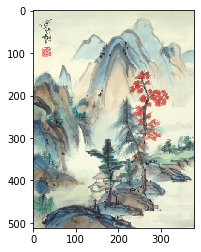

In [5]:
base_img_path = os.path.join(os.path.abspath("Base"), 'Content.jpg')
style_img_path = os.path.join(os.path.abspath("Style"), 'Style.jpg')
width, height = load_img(base_img_path).size
img_nrows = 400
img_ncols = int(width * img_nrows/height)
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.imshow(load_img(style_img_path))
print(img_nrows, img_ncols)

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size = (img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    return img

In [7]:
def deprocess_image(X):
    X = X.reshape((img_nrows, img_ncols, 3))
    #Remove zero_center by mean pixel
    X[:, :, 0] += 103.939
    X[:, :, 1] += 116.779
    X[:, :, 2] += 123.68
    #BGR -> RGB
    X = X[:, :, ::-1]
    X = np.clip(X, 0, 255).astype('uint8')
    return X

In [8]:
base_image = K.variable(preprocess_image(base_img_path))
style_image = K.variable(preprocess_image(style_img_path))

In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))
input_tensor = K.concatenate([base_image, 
                              style_image, 
                              combination_image], axis = 0)
model = vgg19.VGG19(input_tensor = input_tensor, 
                    weights = 'imagenet', 
                    include_top = False)
print('Model Loaded')











Model Loaded


In [10]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict)

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 400, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 400, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 200, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 200, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 100, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 100, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'b

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [12]:
def gram_matrix(X):
    #for each channel flatten out the features
    features = K.batch_flatten(K.permute_dimensions(X, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [13]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2)*(size ** 2))

In [14]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [16]:
def total_variation_loss(X):
    #This loss is calculated on image and not on its features so entire image
    #with 4 dims is passed 
    a = K.square(X[:, :img_nrows - 1, :img_ncols - 1, :] - X[:, 1:, :img_ncols - 1, :])
    b = K.square(X[:, :img_nrows - 1, :img_ncols - 1, :] - X[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a+b, 1.25))
    

In [18]:
#loss tensor
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_img_features = layer_features[0, :, :, :]
combination_img_features = layer_features[2, :, :]
loss = loss + content_weight * content_loss(base_img_features, 
                                            combination_img_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                 'block3_conv1', 'block4_conv1',
                 'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_img_features = layer_features[1, :, :, :]
    combination_img_features = layer_features[2, :, :, :]
    s1 = style_loss(style_img_features, combination_img_features)
    loss = loss + (style_weight/len(feature_layers)) * s1
loss = loss + tv_weight * total_variation_loss(combination_image)

In [19]:
#grads tensor
grads = K.gradients(loss, combination_image)
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
#function to compute loss and gradients from tensors
f_outputs = K.function([combination_image], outputs)

In [21]:
def eval_loss_and_grads(X):
    X = X.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([X])
    loss_value = outs[0]
    if len(outs[1: ]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1]).flatten().astype('float64')
    return loss_value, grad_values

In [22]:
#Evaluator Class so as to encapsulate loss function and gradient function
#to pass in scipy.optimize
class Evaluator():
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    def loss(self, X):
        loss_value, grad_values = eval_loss_and_grads(X)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    def grads(self, X):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [23]:
evaluator = Evaluator()
X = preprocess_image(base_img_path)

In [26]:
for i in range(iteration):
    print("Start of iteration", i)
    start_time = time.time()
    X, min_val, info = fmin_l_bfgs_b(evaluator.loss, X.flatten(), 
                                     fprime = evaluator.grads, maxfun = 20)
    print('Current loss value: ', min_val)
    #Save current generated image
    img = deprocess_image(X.copy())
    fname = "image_at_iteration_%d.png" % i
    save_img("Image_per_iteration" + fname, img)
    end_time = time.time()
    print("Image saved as", fname)
    print("Iterations completed in %d secs" % (end_time - start_time))

Start of iteration 0
Current loss value:  1842939100.0
Image saved as image_at_iteration_0.png
Iterations completed in 299 secs
Start of iteration 1
Current loss value:  1277780900.0
Image saved as image_at_iteration_1.png
Iterations completed in 343 secs
Start of iteration 2
Current loss value:  1072393200.0
Image saved as image_at_iteration_2.png
Iterations completed in 214 secs
Start of iteration 3
Current loss value:  976746900.0
Image saved as image_at_iteration_3.png
Iterations completed in 234 secs
Start of iteration 4
Current loss value:  917268600.0
Image saved as image_at_iteration_4.png
Iterations completed in 290 secs
Start of iteration 5
Current loss value:  873970560.0
Image saved as image_at_iteration_5.png
Iterations completed in 289 secs
Start of iteration 6
Current loss value:  837149300.0
Image saved as image_at_iteration_6.png
Iterations completed in 266 secs
Start of iteration 7
Current loss value:  811083100.0
Image saved as image_at_iteration_7.png
Iterations com